In [190]:
import pandas as pd
import sqlite3 as sql
import numpy as np
import re
import string

# TO-DO:
<s>1) Fix column names in grid mix dataframe</s>

<s> 1.1) Add CO2e calculation, vehicle assembly, battery assembly </s> 

<s> 2) Figure out how to account for PHEV emissions (relevant papers?)</s> 

3) Figure out how to account for HEV battery, if necessary

4) Figure out how to distinguish NIMH/LI battery data 

5) Clean up vehicle_type vs vehicle_class

6) Integrate zip-code choice

<s>  7) Integrate into django Model ORM </s> 

In [185]:
## create combined vehicle emissions:

## join curb_weight_join to weighted total c02 emissions by vehicle
## need to get embodied emissions and in-use emissions 
## embodied_emissions = vehicleCo2_vector*vehicle_C02_weightings*mass_vehicle
## in-use emissions = Co2/mile = mpg(e)*carbon_intensity
## carbon intensity = carbon intensity of fuel or carbon intensity of grid_mix 
## grid_mix carbon_intensitty = c02 emissions at entered zip code or take average of all zip codes
## append in-use emissions, embodied emissions, and total emissions (embodied+in_use) to joined vehicle data

In [226]:
## load in data
## need vehicle data, emissions weightings/intensities by vehicle, zip data
vehicle_data = pd.read_csv("/Users/josheverts/MIMS-Capstone/Data/adj_weight_data_join.csv")
subregion_emissions = pd.read_csv("/Users/josheverts/MIMS-Capstone/Data/subregion_emissions.csv")

## embodied emissions data (includes both weightings and intensities in the same table)
LI_emissions_data = pd.read_csv("/Users/josheverts/MIMS-Capstone/Data/emissions_factor_LI.csv")
NIMH_emissions_data = pd.read_csv("/Users/josheverts/MIMS-Capstone/Data/emissions_factor_NIMH.csv")
vehicle_emissions_data = pd.read_csv("/Users/josheverts/MIMS-Capstone/Data/emissions_factor_vehicle.csv")

In [204]:
## make sure emissions column names are formatted properly
LI_emissions_data.columns = [i.strip(" ,") for i in LI_emissions_data.columns]
NIMH_emissions_data.columns = [i.strip(" ,") for i in NIMH_emissions_data.columns]
vehicle_emissions_data.columns = [i.strip(" ,") for i in vehicle_emissions_data.columns]

In [216]:
## save csvs with formatted column names
## embodied emissions data (includes both weightings and intensities in the same table)
LI_emissions_data.to_csv("/Users/josheverts/MIMS-Capstone/Data/emissions_factor_LI.csv", index = False)
NIMH_emissions_data.to_csv("/Users/josheverts/MIMS-Capstone/Data/emissions_factor_NIMH.csv", index = False)
vehicle_emissions_data.to_csv("/Users/josheverts/MIMS-Capstone/Data/emissions_factor_vehicle.csv", index = False)

In [268]:
vehicle_data[vehicle_data['atvType'] == 'HEV']

,Model_y,Make_y,Year,atvType,cylinders,displ,trany,VehicleID,AdjWeight,comb08,combinedUF,combE,highway08U,rangeHwyA,RangeHwy,Range,city08U,UCity,UHighway
4,Discovery MHEV,Land Rover,2023,HEV,6.0,3.0,Automatic (S8),45104,5250.000000,22.0,0.0,0.0,25.2170,0.0,0.0,0.0,19.4394,24.4829,35.5392
6,Defender 110 MHEV,Land Rover,2023,HEV,6.0,3.0,Automatic (S8),45106,5675.000000,20.0,0.0,0.0,22.6469,0.0,0.0,0.0,18.2647,22.9121,31.5521
7,Defender 90 MHEV,Land Rover,2023,HEV,6.0,3.0,Automatic (S8),45107,5675.000000,20.0,0.0,0.0,22.6469,0.0,0.0,0.0,18.2647,22.9121,31.5521
24,Sportage Hybrid AWD,Kia,2023,HEV,4.0,1.6,Automatic (AM-S6),45207,4119.444444,38.0,0.0,0.0,37.9799,0.0,0.0,0.0,38.2202,52.1815,49.9036
25,Sportage Hybrid FWD,Kia,2023,HEV,4.0,1.6,Automatic (AM-S6),45208,4119.444444,43.0,0.0,0.0,44.3121,0.0,0.0,0.0,42.2521,57.7000,55.6000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
642,Alpina XB7,BMW,2023,HEV,8.0,4.4,Automatic (S8),46156,5500.000000,17.0,0.0,0.0,20.2334,0.0,0.0,0.0,15.5008,19.2000,28.0000
643,Highlander Hybrid AWD LTD/PLAT,Toyota,2023,HEV,4.0,2.5,Automatic (AV-S6),46157,4750.000000,35.0,0.0,0.0,34.0000,0.0,0.0,0.0,35.4652,48.2000,47.0000
644,Highlander Hybrid AWD,Toyota,2023,HEV,4.0,2.5,Automatic (AV-S6),46158,4750.000000,35.0,0.0,0.0,34.7889,0.0,0.0,0.0,35.1424,47.6000,46.4000
649,F150 Pickup 2WD HEV,Ford,2023,HEV,6.0,3.5,Automatic (S10),46166,5693.640351,25.0,0.0,0.0,25.1517,0.0,0.0,0.0,25.1342,32.5000,35.4000


In [228]:
## first average subregion emissions (use CO2e)
## in this table, values are in lbs/MWh
avg_CO2eRate = subregion_emissions['CO2eRate'].mean()
## convert from lbs/MWh to g/kWh
avg_CO2eRate = avg_CO2eRate*453.592/1000

In [232]:
## define functions to import as a file
## Vehicle is planned object which will be one entry taken from EPA vehicle testing database
## User is planned object which will store a user's input
def est_battery_capacity_from_vehicle(Vehicle):
    '''return battery capacity in kwh'''
    kwh_size = 0
    if Vehicle.atvType == 'EV':
        kwh_size = Vehicle.Range*(1/Vehicle.highway08U)*33.7 ## use Range since all EVs have it
    elif Vehicle.atvType == 'PHEV':
        kwh_size = Vehicle.rangeHwyA*(Vehicle.combE/100) ## range*(kWh/100 miles) = kWh estimated
#     print(kwh_size)
    return kwh_size

def est_battery_weight_from_vehicle(Vehicle):
    ''' return battery weight in lbs'''
    battery_weight = est_battery_capacity_from_vehicle(Vehicle)*1/(.2)*2.204 ## assume 0.2 kWh/Kg energy density
#     print(battery_weight)
    return battery_weight 

def est_battery_assembly_emissions(Vehicle, emittant):
    battery_assembly_dict = {'VOC': 2.24, 'CO': 9.129,'NOx': 13.081,'PM10': 0.939,
     'PM2.5': 0.747,'SOx': 3.981,'BC': 0.099,'OC': 0.279,'CH4': 37.428,'N2O': 0.361,
     'CO2': 12374}
    return est_battery_capacity_from_vehicle(Vehicle)*battery_assembly_dict[str(emittant)]


def weighted_emissions_calc(vehicle_weight, mass_fractions, emissions_vector):
    mass_fractions = np.array(mass_fractions)
    emissions_vector = np.array(emissions_vector)
    return np.sum(vehicle_weight*mass_fractions*emissions_vector)

def get_PHEV_usage_emissions(Vehicle, miles_estimated, grid_intensity):
    '''implement PHEV emissions calculation using EPA utility factor'''
    utility_factor = Vehicle.combinedUF
    electric_eff = Vehicle.combE ## in kwh/100 miles (average energy consumption in both hybrid and EV modes)
    permile_electric_eff = electric_eff/100
    combined_mpge = Vehicle.comb08
    
    grid_carbon = grid_intensity*permile_electric_eff*miles_estimated 
    fuel_carbon = (combined_mpge**-1)*miles_estimated*8900 ## consumption in hybrid mode (EV mode is zero fuel)
    
    
    return 1/((1/grid_carbon) + (1-utility_factor)/fuel_carbon) ## electric_eff always applies (no weight)
    
    
##
## need to fix this to work with Hybrid vehicles (how to estimate HEV battery size?)
## update to also work with lightweight versions correctly
##
def get_embodied_emissions(vehicle_weight, battery_weight, vehicle_type, emissions_type, vehicle_emissions_manufacturing, battery_emissions_manufacturing):
    vehi_sum = weighted_emissions_calc(vehicle_weight, vehicle_emissions_manufacturing[str(emissions_type)], 
                                       vehicle_emissions_manufacturing[str(vehicle_type)])
    if vehicle_type == 'ICEV: Conventional Material' or vehicle_type == 'HEV: Conventional Material':
        battery_sum = 0
        fluids = 634200
    elif vehicle_type == 'PHEV: Conventional Material':
        battery_sum = weighted_emissions_calc(battery_weight, battery_emissions_manufacturing[str(emissions_type)], 
                                       battery_emissions_manufacturing[str(vehicle_type)]) 
        fluids = 571000
    else:
        battery_sum = weighted_emissions_calc(battery_weight, battery_emissions_manufacturing[str(emissions_type)], 
                                              battery_emissions_manufacturing[str(vehicle_type)])
        fluids = 82000
        
    if emissions_type == 'CO2':
        ## terms assumed constant:
        lead_acid_battery = 60000
        vehicle_adr = 874000
        battery_sum+=lead_acid_battery
        return battery_sum, vehi_sum, (vehi_sum + battery_sum + fluids + vehicle_adr)
    else: ## assume for other emittants the constant terms are negible (don't add them)
        return battery_sum, vehi_sum, (vehi_sum + battery_sum)
        

# def est_embodied_emissions(Vehicle):
#     ## account for EV battery or ICE
#     if Vehicle.battery == True:
#         battery = True
#         kwh_size = est_battery_capacity_from_vehicle(Vehicle)
#     else:
#         battery = False
#         kwh_size = 0
#     vehicle_weight = Vehicle.weight
#     ## send estimated battery capacity and vehicle weight to embodied emissions function
#     embodied_emissions = get_embodied_emissions(vehicle_weight, battery_weight)  
#     return embodied_emissions

# def get_grid_carbon(user_zip, Zip, Co2):
#     ## store lookup table of CO2 intensity by grid region
#     ## convert User zipcode input to grid region
# #     user_region = Zip[Zip['ZIP'] == user_zip]
# #     Co2 = Co2[Co2['Co2'] == user_region]
#     return Co2
    

def get_usage_emissions(Vehicle, vehicle_fuel_economy, vehicle_class, 
                        miles_estimated, grid_intensity = avg_CO2eRate):

    if vehicle_class == 'ICE' or vehicle_class == 'HEV':
        return (vehicle_fuel_economy**-1)*miles_estimated*8900 ## (g/mile*miles*8900gCo2/gallon)
    elif vehicle_class == 'EV':
        grid_carbon = grid_intensity*((vehicle_fuel_economy/33.7)**-1)*miles_estimated ## convert mpge to kwh/mile, return gC
        return grid_carbon ## carbon per kwh*kwh/gallon
    elif vehicle_class == 'PHEV': ## assume vehicle is driven in combined cycle (battery and engine)
        return get_PHEV_usage_emissions(Vehicle, miles_estimated, grid_intensity) ## 8.9 kgC02 per gallon
    else:
        return 0

# def est_lifetime_emissions(Vehicle, User):
#     ## account for EV battery or ICE
#     embodied_emissions = est_embodied_emisions(Vehicle)
#     usage_emissions = est_usage_emissions(Vehicle,User)
#     return embodied_emissions+usage_emissions

def conv_or_lw(vehicle_class, lightweight=False):
    '''input vehicle_class (Vehicle.atvType) and Boolean (lightweight = False for conventional)'''
    
    possible_columns = ['ICEV: Conventional Material', 'ICEV: Lightweight Material',
       'HEV: Conventional Material', 'HEV: Lightweight Material',
       'PHEV: Conventional Material', 'PHEV: Lightweight Material',
       'EV: Conventional Material', 'EV: Lightweight Material',
       'FCV: Conventional Material', 'FCV: Lightweight Material']
    
    if not lightweight:
        if vehicle_class == 'ICE':
            return possible_columns[0]
        elif vehicle_class == 'HEV':
            return possible_columns[2]
        elif vehicle_class == 'PHEV':
            return possible_columns[4]
        elif vehicle_class == 'EV':
            return possible_columns[6]
        else:
            return possible_columns[8]
    elif lightweight:
        if vehicle_class == 'ICE':
            return possible_columns[1]
        elif vehicle_class == 'HEV':
            return possible_columns[3]
        elif vehicle_class == 'PHEV':
            return possible_columns[5]
        elif vehicle_class == 'EV':
            return possible_columns[7]
        else:
            return possible_columns[9]
    else:
        print("there was an error with get_emissions_weights lightweight parameter")
        return
        
        

emittant_dictionary = {'CO2':1, 'CH4':25, 'N2O':298} ## from IPCC report (wikipedia/GWP)
def get_CO2e(value, emittant, conversions=emittant_dictionary):
    '''given a GHG emittant and a emissions value, return CO2e.
    Use global-warming-potential at 100 years as a scaling factor'''
#     print(value)
    return value*conversions[emittant]
    
        
def process_vehicle(Vehicle, Manufacturing, Battery, emissions_types):
    vehicle_fuel_economy = Vehicle.highway08U*.55 + Vehicle.city08U*.45 ## combined fuel economy (EPA.gov)
    vehicle_weight = Vehicle.AdjWeight
    vehicle_class = Vehicle.atvType
    vehicle_type = conv_or_lw(vehicle_class)
    battery_weight = est_battery_weight_from_vehicle(Vehicle)
    
    lifetime_emissions = []
    total_embodied = 0
    for emittant in emissions_types:
        battery, vehicle, total = get_embodied_emissions(vehicle_weight, battery_weight, 
                                          vehicle_type, emittant, 
                                          Manufacturing, Battery)

        batt_assembly = est_battery_assembly_emissions(Vehicle, emittant)
        total += batt_assembly
#         print(embodied)
        embodied_CO2e = get_CO2e(total, emittant)
        total_embodied+=embodied_CO2e ## for every emittant, add to total
        
        ## for ICE vehicles, CO2 ~ CO2e
        ## for grid mix, select CO2e option
    usage = get_usage_emissions(Vehicle, vehicle_fuel_economy, vehicle_class, miles_estimated=178000)
    lifetime_emissions.append([batt_assembly, battery, vehicle, total_embodied, usage, (total_embodied + usage)])
    return lifetime_emissions

    

In [233]:
## Approach: since here we aren't taking a specific zip code, average C02 emissions across all zip codes
## then for a given vehicle type calculate in-use emissions according to efficiency*carbon_intensity
## for ICE vehicles, use mpge*cabon_intensity_petrol
## for EVs, use average grid mix intensity
## for PHEVs, use mpge*carbon_intensity_petrol, assume combined cycle driving

In [234]:
## for each row of vehicle df (a Vehicle) get emissions for specified GHGs
## assuming lithium batteries for now, because we are ignoring HEV batteries (as they are very small)
## fix column names in vehicle emissionsn data
emissions_array = []
for i in range(len(vehicle_data)):
    Vehicle = vehicle_data.iloc[i]
    lifetime_emissions = process_vehicle(Vehicle, vehicle_emissions_data, LI_emissions_data, ['CO2'])
    emissions_array.append(lifetime_emissions)
emissions_array = np.array(emissions_array).squeeze()

In [235]:
np.mean(emissions_array, axis = 0)

array([  105383.35785443,   421305.56292666,  6737386.15817078,
        8715084.28397281, 63347422.57432606, 72062506.8582989 ])

In [237]:
vehicle_data['battery_assembly'] = 

,Model_y,Make_y,Year,atvType,cylinders,displ,trany,VehicleID,AdjWeight,comb08,combinedUF,combE,highway08U,rangeHwyA,RangeHwy,Range,city08U,UCity,UHighway
0,Defender 90,Land Rover,2023,ICE,4.0,2.0,Automatic (S8),45099,5675.000000,19.0,0.0,0.0,20.7578,0.0,0.0,0.0,17.8574,22.3491,30.5805
1,Sportage FWD,Kia,2023,ICE,4.0,2.5,Automatic (S8),45101,4119.444444,28.0,0.0,0.0,31.7208,0.0,0.0,0.0,24.8603,32.1057,45.6871
2,Sportage AWD,Kia,2023,ICE,4.0,2.5,Automatic (S8),45102,4119.444444,25.0,0.0,0.0,28.4399,0.0,0.0,0.0,22.6477,28.9565,40.4900
3,Discovery,Land Rover,2023,ICE,4.0,2.0,Automatic (S8),45103,5250.000000,21.0,0.0,0.0,22.2428,0.0,0.0,0.0,19.3318,24.3528,33.7329
4,Discovery MHEV,Land Rover,2023,HEV,6.0,3.0,Automatic (S8),45104,5250.000000,22.0,0.0,0.0,25.2170,0.0,0.0,0.0,19.4394,24.4829,35.5392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,RC F,Lexus,2023,ICE,8.0,5.0,Automatic (S8),46350,4125.000000,19.0,0.0,0.0,24.4289,0.0,0.0,0.0,16.3887,20.4000,33.3000
713,Tucson FWD,Hyundai,2023,ICE,4.0,2.5,Automatic (S8),46375,4105.555556,28.0,0.0,0.0,31.8471,0.0,0.0,0.0,24.9271,32.2017,45.8896
714,Bronco Sport 4WD,Ford,2023,ICE,3.0,1.5,Automatic 8-spd,46385,5665.178571,26.0,0.0,0.0,28.0000,0.0,0.0,0.0,25.3012,32.7408,43.3816
715,Bronco Sport 4WD,Ford,2023,ICE,4.0,2.0,Automatic (S8),46386,5665.178571,23.0,0.0,0.0,26.0000,0.0,0.0,0.0,21.1067,26.8000,39.2000


In [238]:
emissionsdf = pd.DataFrame(emissions_array)

In [240]:
emissionsdf.columns = ['battery_assembly', 'battery_manufacture', 
                       'vehicle_manufacture', 'total_embodied', 'usage', 'total']

In [245]:
emissionsjoin = pd.merge(vehicle_data, emissionsdf, left_index = True, right_index = True)

In [246]:
emissionsjoin

,Model_y,Make_y,Year,atvType,cylinders,displ,trany,VehicleID,AdjWeight,comb08,...,Range,city08U,UCity,UHighway,battery_assembly,battery_manufacture,vehicle_manufacture,total_embodied,usage,total
0,Defender 90,Land Rover,2023,ICE,4.0,2.0,Automatic (S8),45099,5675.000000,19.0,...,0.0,17.8574,22.3491,30.5805,0.0,60000.0,8.305035e+06,9.873235e+06,8.143890e+07,9.131214e+07
1,Sportage FWD,Kia,2023,ICE,4.0,2.5,Automatic (S8),45101,4119.444444,28.0,...,0.0,24.8603,32.1057,45.6871,0.0,60000.0,6.028569e+06,7.596769e+06,5.532666e+07,6.292343e+07
2,Sportage AWD,Kia,2023,ICE,4.0,2.5,Automatic (S8),45102,4119.444444,25.0,...,0.0,22.6477,28.9565,40.4900,0.0,60000.0,6.028569e+06,7.596769e+06,6.132369e+07,6.892046e+07
3,Discovery,Land Rover,2023,ICE,4.0,2.0,Automatic (S8),45103,5250.000000,21.0,...,0.0,19.3318,24.3528,33.7329,0.0,60000.0,7.683072e+06,9.251272e+06,7.568009e+07,8.493136e+07
4,Discovery MHEV,Land Rover,2023,HEV,6.0,3.0,Automatic (S8),45104,5250.000000,22.0,...,0.0,19.4394,24.4829,35.5392,0.0,60000.0,6.853644e+06,8.421844e+06,7.004441e+07,7.846625e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712,RC F,Lexus,2023,ICE,8.0,5.0,Automatic (S8),46350,4125.000000,19.0,...,0.0,16.3887,20.4000,33.3000,0.0,60000.0,6.036699e+06,7.604899e+06,7.612390e+07,8.372880e+07
713,Tucson FWD,Hyundai,2023,ICE,4.0,2.5,Automatic (S8),46375,4105.555556,28.0,...,0.0,24.9271,32.2017,45.8896,0.0,60000.0,6.008244e+06,7.576444e+06,5.513502e+07,6.271146e+07
714,Bronco Sport 4WD,Ford,2023,ICE,3.0,1.5,Automatic 8-spd,46385,5665.178571,26.0,...,0.0,25.3012,32.7408,43.3816,0.0,60000.0,8.290662e+06,9.858862e+06,5.914385e+07,6.900271e+07
715,Bronco Sport 4WD,Ford,2023,ICE,4.0,2.0,Automatic (S8),46386,5665.178571,23.0,...,0.0,21.1067,26.8000,39.2000,0.0,60000.0,8.290662e+06,9.858862e+06,6.656858e+07,7.642744e+07


array([[<AxesSubplot:title={'center':'total_embodied'}>]], dtype=object)

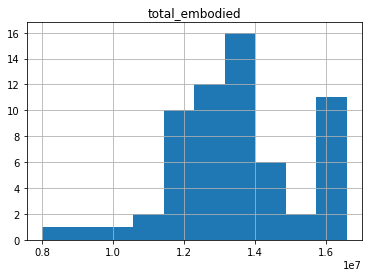

In [248]:
## some simple checks
emissionsjoin[emissionsjoin['atvType'] == 'EV'].hist('total_embodied')

array([[<AxesSubplot:title={'center':'total_embodied'}>]], dtype=object)

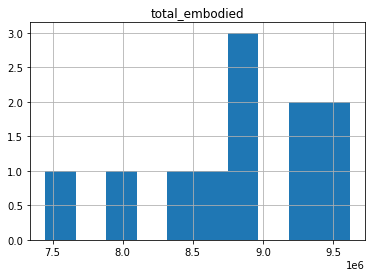

In [249]:
## some simple checks
emissionsjoin[emissionsjoin['atvType'] == 'PHEV'].hist('total_embodied')

array([[<AxesSubplot:title={'center':'total_embodied'}>]], dtype=object)

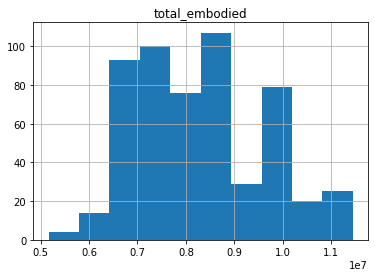

In [250]:
## some simple checks
emissionsjoin[emissionsjoin['atvType'] == 'ICE'].hist('total_embodied')

array([[<AxesSubplot:title={'center':'total_embodied'}>]], dtype=object)

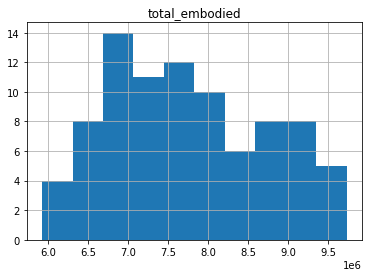

In [269]:
## some simple checks
emissionsjoin[emissionsjoin['atvType'] == 'HEV'].hist('total_embodied')

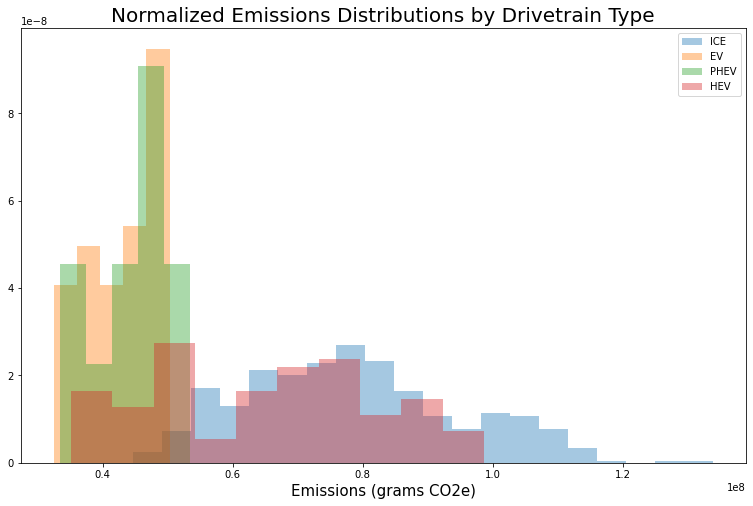

In [281]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (13,8))
plt.title('Normalized Emissions Distributions by Drivetrain Type', size = 20)
plt.hist(emissionsjoin[emissionsjoin['atvType'] == 'ICE']['total'], density = True, label = 'ICE', bins = 20, alpha = 0.4)
plt.hist(emissionsjoin[emissionsjoin['atvType'] == 'EV']['total'],density = True, label = 'EV', bins = 5, alpha = 0.4)
plt.hist(emissionsjoin[emissionsjoin['atvType'] == 'PHEV']['total'],density = True, label = 'PHEV', bins = 5, alpha = 0.4)
plt.hist(emissionsjoin[emissionsjoin['atvType'] == 'HEV']['total'],density = True, label = 'HEV', bins = 10, alpha = 0.4)
plt.xlabel('Emissions (grams CO2e)', size = 15)
plt.legend()
plt.show()

In [285]:
emissionsjoin.to_csv("emissions_vehicle_join_adjweights.csv", index = False)